<a href="https://colab.research.google.com/github/GiovaniValdrighi/style_transfer/blob/main/notebooks/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

Reprodução do algoritmo de transferência de estilo do artigo  *A Neural Algorithm of Artistic Style*, de Leon A. Gays, Alexander S. Ecker e Matthis Bethge. 

In [ ]:
import torch
import urllib
import torch.nn as nn
from PIL import Image
import pickle as pkl
from torchvision import transforms
import torch.optim as optim
from torchvision.models import vgg19
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Introdução
Em arte, principalmente em pinturas, os humanos dominaram a construção de experiências visuais que são formadas por uma complexa combinação do conteúdo e do estilo. Tal produção ainda não possui um algoritmo, e se é questionado se é possível a existência de um algoritmo de criação de grandes obras de arte.

A área de visualização teve um grande desenvolvimento com o uso de redes neurais e Deep Learning, as redes convolucionais são extremamente potentes, sendo capazes de detectar objetos em imagens, detectar padrões.

Quando as CNN são treinadas para a detecção de objetos, as camadas da rede aprendem a construir uma representação do conteúdo da imagem que vai além dos simples valores dos pixels, essa representação contém as principais características necessárias para as últimas camadas detectar qual é o objeto. Nesse trabalho, foi usado o resultado das últimas camadas de uma rede convolucional como a representação do conteúdo (content representation) da imagem de entrada.

Para a representação do estilo (style representation) é utilizado um filtro que captura texturas, mas é usado diferentes camadas da rede para obter uma representação global do estilo.

A principal descoberta desse artigo foi que a representação do conteúdo e do estilo de uma imagem são separáveis a partir dos resultados da rede convolucional.

![picture](https://raw.githubusercontent.com/GiovaniValdrighi/style_transfer/main/notebooks/images/content_style.jpg)

Como podemos obter a representação de estilo de uma imagem e a representação de conteúdo de uma imagem, o método proposto para trasferência de estilo faz é utilizar duas imagens, a imagem de conteúdo e a imagem de estilo, obter a representação delas, e com uma nova imagem, que pode ser um ruído qualquer, otimizar essa imagem para diminuir a distância da sua representação de estilo com a representação de estilo da imagem de estilo e diminuir a distância da sua representação de conteúdo com a representação de conteúdo da imagem de conteúdo.

## Pré-processamento das imagens

Usaremos a rede pré-treinada VGG-19 como rede convolucional para a representação de conteúdo e estilo de imagens. A rede foi apresentada em 2014, e a versão VGG-19 em específico possui 19 camadas de profundidade.

![picture](https://raw.githubusercontent.com/GiovaniValdrighi/style_transfer/main/notebooks/images/vgg19.png)


Como será utilizada a rede pré treinada VGG-19, devemos adequar as nossas imagens para essa rede. As entradas devem ter dimensão $[224, 224]$. Para isso, iremos transformar a imagem original para ter largura $256$ e pegar o quadrado $[224, 224]$ central. Além disso, o ideal para a rede é uma imagem com média $[0.485, 0.456, 0.406]$ e desvio padrão $[0.229, 0.224, 0.225]$.

Essas condições de entrada da rede VGG-19 se tornam um grande limite para o nosso método, pois não podemos treinar imagens em alta resolução com grandes dimensões. Além disso, existe uma pequena dificuldade em retornar a imagem para a média e o desvio padrão originais.


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(path):
    '''Function that load the image and preprocess to the VGG19 format
    The image must be with shape 224x224, with mean [0.485, 0.456, 0.406]
    and standard deviation [0.229, 0.224, 0.225]'''
    img = Image.open(path)
    return preprocess(img).unsqueeze(0)


## Modelo

O modelo irá utilizar a rede convolucional VGG_19 que a API do Pytorch possibilita o acesso. Ele irá receber duas lista de índices de quais camadas deve utilizar para obter a representação de conteúdo e de estilo, por padrão, as camadas utilizadas no paper são as seguintes:

* Conteúdo : [21] = ['Conv4_2']
* Estilo : [0, 5, 10, 19, 28] = ['Conv1_1', 'Conv2_1', 'Conv3_1', 'Conv4_1', 'Conv5_1']

O treinamento neste trabalho utiliza as mesmas camadas, mas este é um parâmetro ajustável da função. O que o modelo faz é receber a imagem de treinamento, passar ela pelas camadas e verificar se a camada é ou uma camada de estilo ou de conteúdo, e caso seja, ele salva esse resultado.

In [ ]:
class vgg19_mod(nn.Module):
    def __init__(self, content_layers, style_layers):
        '''
        Class that initialize the VGG19 model and set the intermediate style and content layers

        Inputs:
            style_layers : list of index of the style layers in the VGG19 net
            content_layers: list of index of the content layers in the VGG19 net
        '''
        super(vgg19_mod, self).__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
        self.style_layers = style_layers
        self.content_layers = content_layers

    def forward(self,  input):
        '''
        Forward process that pass the input image trought the VGG 19 net and keeps the intermediates outputs

        Inputs:
            input : tensor of shape [batch, 3, 224, 224] 

        Outputs:
            style_out : list of style layers outputs
            cotent_out : list of content layers outputs
        '''
        style_out = []
        content_out = []
        for i, model in enumerate(self.features):
            input = model(input)
            if i in self.style_layers:
                style_out.append(input)
            if i in self.content_layers:
                content_out.append(input)
        return content_out, style_out


## Função de perda

Seja $\pmb x$ o tensor da imagem que vamos treinar, $\pmb p$ é o tensor da imagem de conteúdo e $\pmb a$ o tensor da imagem de estilo. A função de perda (loss) será definida por dois termos, a perda de conteúdo e de estilo.

Definimos $F^l$ como a representação de conteúdo de $\pmb x$ na camada $l$ e $P^l$ a representação de conteúdo de $\pmb p$ na camada $l$. Se $l$ é uma camada que gera $N_l$ filtros com um total de $M_l$ elementos (largura vezes altura), então $F_l \in \mathbb {R}^{N_l \times M_l}$ e $P_l \in \mathbb {R}^{N_l \times M_l}$. A nossa perda será a distância quadrática média $F_l$ e $P_l$.

$L_{content}(\pmb x, \pmb p, \pmb l) = \dfrac{1}{N_l M_l}\sum_{i,j}(F_{ij}^l - P_{ij}^l)^2$

In [ ]:
def content_loss(pred, target):
    '''The content loss is the mean squared error'''
    return torch.pow(pred - target, 2).mean()

Para a perda do estilo, em cada uma das camadas usadas para o estilo, iremos utilizar um método para cálculo de textura que computa a correlação, esse fator é a matriz de Gram $G_l$, que é definida como, o produto interno das colunas de $F_l$ (a representação do tensor que estamos treinando $\pmb x$). Agora seja $\pmb a$ o tensor de estilo e $A_l$ a matriz de Gram calculada para a representação de $\pmb a$ na camda $l$. A perda do estilo será definida como:

$L_{style}(\pmb x, \pmb a, \pmb l) = \dfrac{1}{N_l M_l}\sum_{i,j}(G_{ij}^l - A_{ij}^l)^2$

In [ ]:
def gram_matrice(input):
    '''
    Compute the gram matrice of the input tensor
    The gram matrice of V is V'V, but we have to change the input to 2 dimensios
    Than we normalize by the number of elements
    '''
    batch, channel, width, height = input.size()
    M = input.view(batch * channel, width * height)
    gram = torch.mm(M, M.t())
    return gram.div(batch*width*height*channel)

def style_loss(pred, gram_target):
    '''The style loss if the euclidian distance of the Gram matrice '''
    gram_pred = gram_matrice(pred)
    return torch.pow(gram_pred - gram_target, 2).mean()

A perda final tem então a seguinte forma:

$L_{total}(\pmb x, \pmb p, \pmb a) = \alpha L_{content}(\pmb x, \pmb p) + \beta L_{style}(\pmb x, \pmb a) $

Sendo $\alpha$ e $\beta$ os parâmetros que escolhemos para o treinamento dar mais prioridade para o conteúdo e para o estilo, reespectivamente.

## Treinamento

Por fim, o treinamento ocorre da seguinte forma:
1. Instanciamos o modelo.
2. Obtemos as representações de conteúdo e de estilo das imagens de conteúdo e de estilo, reespectivamente.
3. Definimos uma imagem que será otimizada, o valor inicial dela é o mesmo da imagem de conteúdo.
4. Instanciamos o otimizador L-BFGS.
5. Para cada iteração da otimização:
    * Computamos a representação de conteúdo e de estilo da imagem de treinamento.
    * Computamos a perda de conteúdo e de estilo das representações.
    * Com o método de backward do Pytorch, computamos os gradientes da perda.
    * Passamos o valor da perda e o valor do gradiente para o método do L-BFGS dar um passo (step).
6. Por fim, invertemos a transformação inicial de pré-processamento, retornando a média e o desvio padrão originais.

In [ ]:
def run_style_transfer(content_path, style_path, iterations = 20, content_layers = None, style_layers = None, 
                       content_weight = 1, style_weight = 1000000, verbose = False, cuda = False, return_loss = False):
    '''
    Training process for the neural style transfer VGG19
    The method uses two images, the content and the style image, and generate a image that 
    contain the content and the style of the reespective images
    The optimization is done by LBFGS

    Inputs:
        content_path : path for the content image
        style_path : path for the style image
        iterations: number of iterations to converge
        content_layers : list of index of VGG19 content layers
        style_layers : list of index of VGG19 style layers
        content_weight : weight of the content loss
        style_weight : weight of the style loss
        verbose : if the function will print intermediate steps
        cuda: if the function will process using GPU
        return_loss: if the function will return the loss value for each epoch

    Outputs:
        init_image : result image with content and style

    '''
    if cuda:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print("Running model with", device)
    else:
        device = torch.device('cpu')

    #Create loss dict
    if return_loss:
        losses = {'style_loss': [], 'content_loss': [], 'total_loss':[]}

    #Setting intermediate layers
    if content_layers is None:
        content_layers = [22]

    if style_layers is None:
        style_layers = [1, 6, 11, 20, 29]

    #Loading the model
    model = vgg19_mod(content_layers, style_layers).to(device)
        
    if verbose:
        print('Initialized model.')

    #Loading the images as tensors
    content_img = load_image(content_path).to(device)
    style_img = load_image(style_path).to(device)
    init_img = load_image(content_path).to(device)
    if verbose:
        print('Initialized images.')

    #Getting the content and style outputs
    content_out, _ = model(content_img)
    _, style_out = model(style_img)
    if verbose:
        print('Calculated images outputs.')

    #Pre-calculating the gram matrice for the styles outputs
    gram_out = [gram_matrice(out) for out in style_out]

    #Setting optmizer
    optmizer = optim.LBFGS([init_img.requires_grad_()])
    if verbose:
        print('Starting optimization.')
    for iter in tqdm(range(iterations)):
        if return_loss:
            _iter_style_loss = []
            _iter_content_loss = []
            _iter_total_loss = []

        def closure():
            '''Calculate ouputs, loss and gradients'''
            optmizer.zero_grad()

            init_content_out, init_style_out = model(init_img)
            
            _content_loss = 0
            for l in range(len(content_out)):
                _content_loss += content_loss(init_content_out[l], content_out[l])

            _style_loss = 0
            for l in range(len(style_out)):
                _style_loss += style_loss(init_style_out[l],  gram_out[l])

            _content_loss *= content_weight
            _style_loss *= style_weight

            loss = _content_loss + _style_loss

            loss.backward(retain_graph=True)

            if iter % 100 == 0 and iter > 0:
                if verbose:
                    print('Iteration %d.  Model loss %.8f'%(iter, loss))
                    print('Content loss: %.8f | Style loss: %.8f'%(_content_loss, _style_loss))
                    print()

            #Update loss dict
            if return_loss:
                _iter_style_loss.append(_style_loss.clone().data.cpu().numpy())
                _iter_content_loss.append(_content_loss.clone().data.cpu().numpy())
                _iter_total_loss.append(loss.clone().data.cpu().numpy())
            
            return _content_loss + _style_loss
        optmizer.step(closure)
        if return_loss:
            losses['style_loss'].append(_iter_style_loss[-1])
            losses['content_loss'].append(_iter_content_loss[-1])
            losses['total_loss'].append(_iter_total_loss[-1])
            

    #Invert VGG19 input transformation
    invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                   transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ])])
    inv_img = invTrans(init_img.squeeze(0))
    
    if return_loss:
        return inv_img, losses
    else:
        return inv_img

## Exemplos


### Gata e Noite estrelada de Van Gogh

Como primeiro exemplo, vamos utilizar a imagem de uma gata e a pintura Noite Estrelada do Van Gogh, no entanto, vamos variar os parâmetros $\alpha$ e $\beta$ para observar o resultado na imagem final. Na realidade, iremos variar apenas a ração $\dfrac{\beta}{\alpha}$, pois o resultado é o mesmo.

In [ ]:
cat_path = '/content/cat.jpg'
stary_night_path = '/content/stary_night.jpg'
cat_stary_dict = {}
for ratio in [1e5, 1e6, 1e7]:
    cat_stary_dict[ratio] = run_style_transfer(cat_path, stary_night_path, 
                                                             verbose = False, cuda = True,
                                                             content_weight = 1,
                                                             style_weight = ratio)

A imagem utilizada como conteúdo e como estilo são as seguintes.

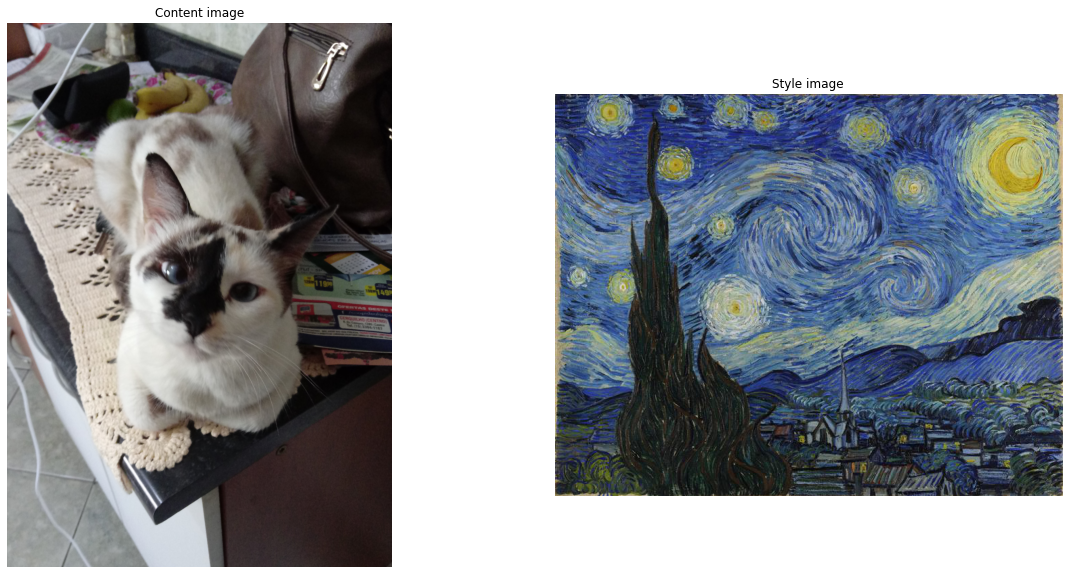

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Content image')
content_image = Image.open('cat.jpg')
ax[0].imshow(content_image)
ax[0].axis('off')

ax[1].set_title("Style image")
style_image = Image.open('stary_night.jpg')
ax[1].imshow(style_image)
ax[1].axis('off')
plt.show()

E o resultado final é o seguinte, para cada uma das razões:

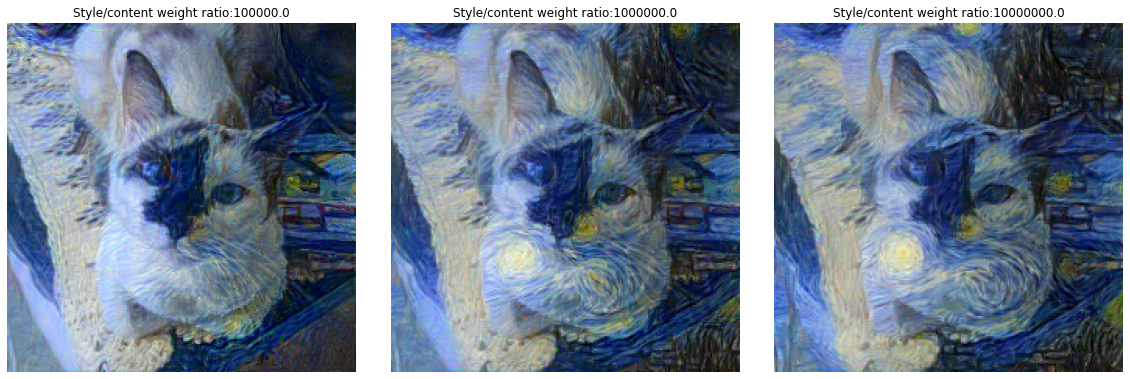

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(20)
fig.set_figheight(12)
for i, ratio in enumerate([1e5, 1e6, 1e7]):
    img = cat_stary_dict[ratio].cpu().detach().permute(1, 2, 0).data.clamp_(0, 1).numpy()
    #img -= img.min()
    #img /= img.max()
    #print(img.min(), img.max())
    ax[i].imshow(img)
    ax[i].set_title("Style/content weight ratio:" + str(ratio))
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()

### Cachorro e pintura O Grito de Edvard Munch

In [ ]:
dog_path = '/content/little_dog.jpg'
grito_path = '/content/scream.jpg'
dog_grito_dict = {}
for ratio in [1e5, 1e6, 1e7]:
    dog_grito_dict[ratio] = run_style_transfer(dog_path, grito_path, iterations = 50, 
                                                             verbose = False, cuda = True,
                                                             content_weight = 1,
                                                             style_weight = ratio)

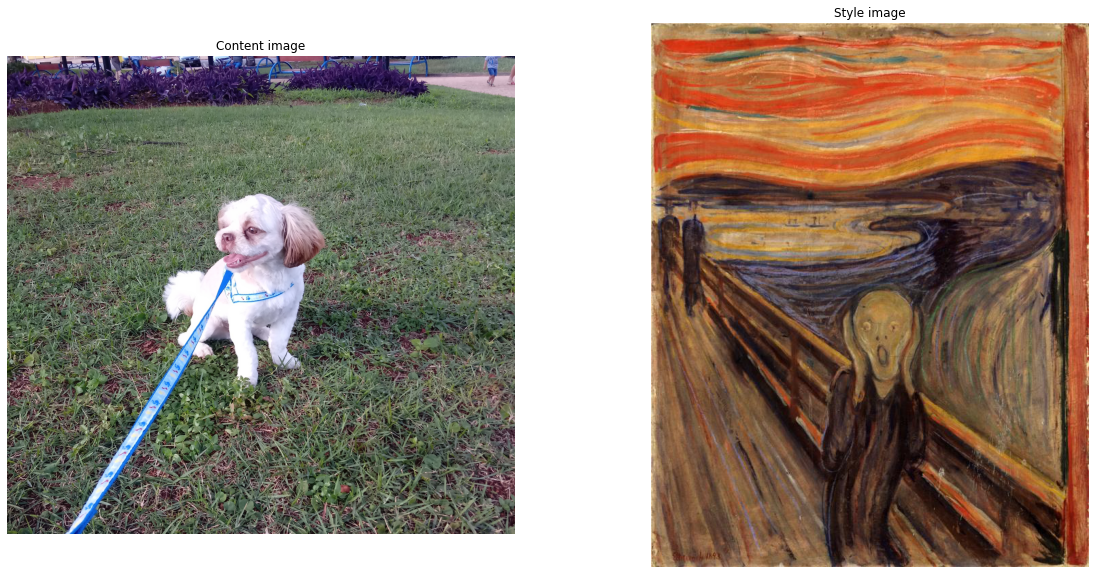

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Content image')
content_image = Image.open('little_dog.jpg')
ax[0].imshow(content_image)
ax[0].axis('off')

ax[1].set_title("Style image")
style_image = Image.open('scream.jpg')
ax[1].imshow(style_image)
ax[1].axis('off')
plt.show()

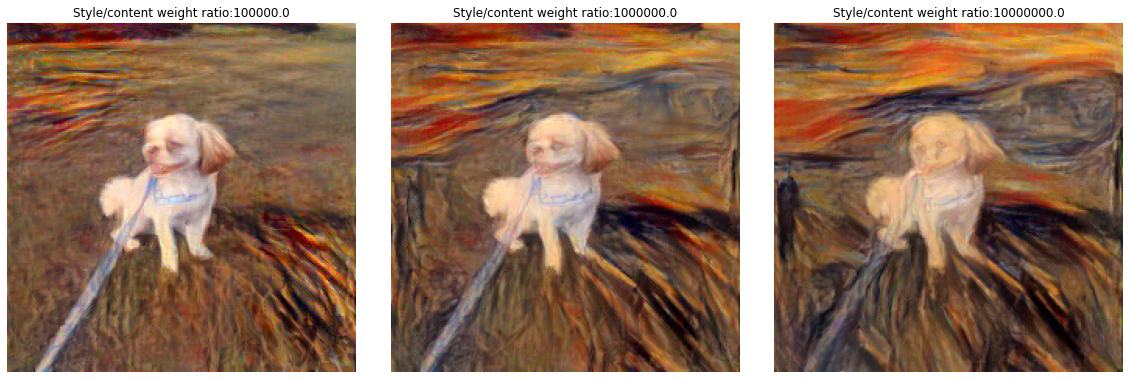

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(20)
fig.set_figheight(12)
for i, ratio in enumerate([1e5, 1e6, 1e7]):
    img = dog_grito_dict[ratio].cpu().detach().permute(1, 2, 0).data.clamp_(0, 1).numpy()
    ax[i].imshow(img)
    ax[i].set_title("Style/content weight ratio:" + str(ratio))
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()

## Análise do treinamento

Vamos começar observando o comportamento da loss ao decorrer das iterações e encontrar o número de iterações que otimiza o tempo de processamento e o valor da loss. Queremos obter esse valor ótimo para sermos capazes de processar uma grande quantidade de imagens, como é necessário ao aplicarmos o método em um vídeo.

In [ ]:
cat_stary, cat_stary_loss = run_style_transfer('cat.jpg', 'stary_night.jpg', iterations = 100, 
                                               cuda = True, return_loss = True)

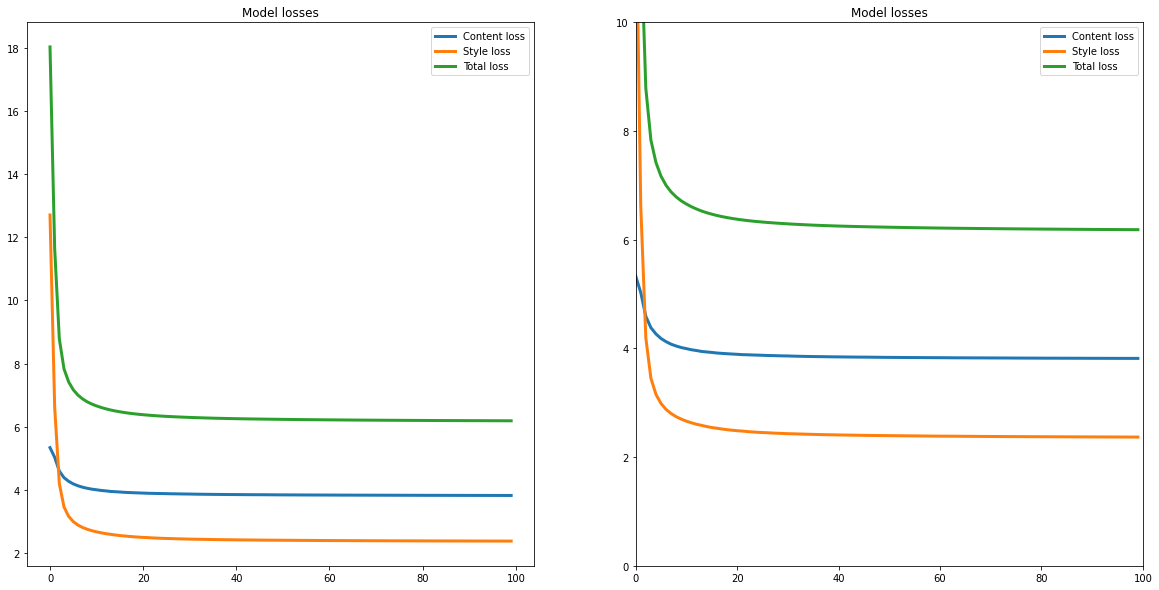

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Model losses')
ax[0].plot(list(range(len(cat_stary_loss['content_loss']))), cat_stary_loss['content_loss'],
           linewidth = 3, label = 'Content loss')
ax[0].plot(list(range(len(cat_stary_loss['style_loss']))), cat_stary_loss['style_loss'],
           linewidth = 3, label = 'Style loss')
ax[0].plot(list(range(len(cat_stary_loss['total_loss']))), cat_stary_loss['total_loss'],
           linewidth = 3, label = 'Total loss')

ax[0].legend()

ax[1].set_title("Style loss")
ax[1].set_title('Model losses')
ax[1].plot(list(range(len(cat_stary_loss['content_loss']))), cat_stary_loss['content_loss'],
           linewidth = 3, label = 'Content loss')
ax[1].plot(list(range(len(cat_stary_loss['style_loss']))), cat_stary_loss['style_loss'],
           linewidth = 3, label = 'Style loss')
ax[1].plot(list(range(len(cat_stary_loss['total_loss']))), cat_stary_loss['total_loss'],
           linewidth = 3, label = 'Total loss')
ax[1].set_ylim(0, 10)
ax[1].set_xlim(0, 100)
ax[1].legend()

plt.show()

Vemos que o método tem uma rápida convergência, mantendo o mesmo valor da loss para todas as iterações após as 20 primeiras. Dessa forma, podemos realizar o treinamento com apenas 30 iterações para evitar extra processamento.

In [ ]:
images = [('/content/jovem.jpg','/content/natureza_morta.jpg'), 
          ('/content/fgv.jpg', '/content/picasso.jpg')]
images_style = []
for im in images:
    images_style.append(run_style_transfer(im[0], im[1], iterations = 20, 
                                                             verbose = False, cuda = True,
                                                             style_weight = ratio))

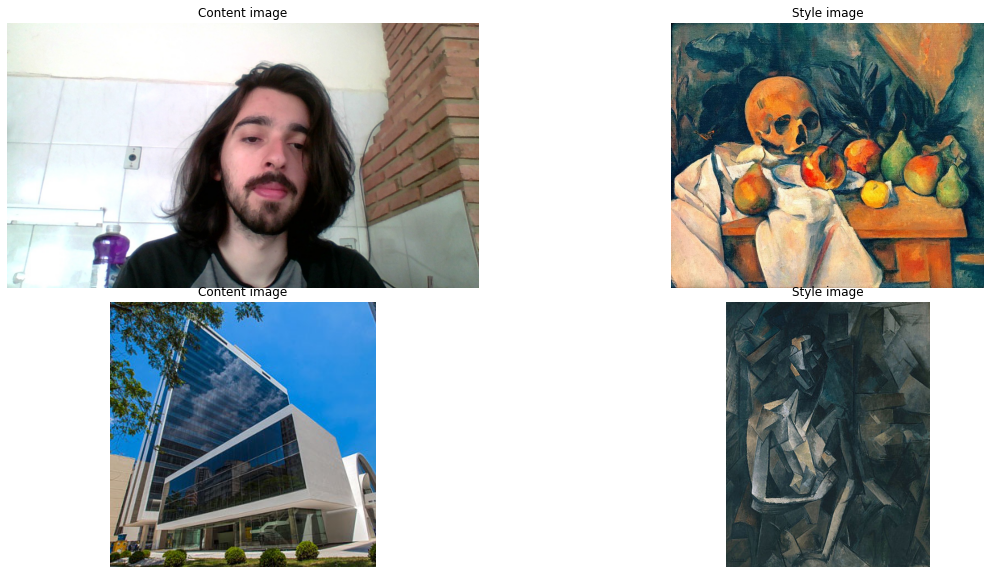

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
ax = ax.flatten()
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Content image')
content_image = Image.open(images[0][0])
ax[0].imshow(content_image)
ax[0].axis('off')

ax[1].set_title("Style image")
style_image = Image.open(images[0][1])
ax[1].imshow(style_image)
ax[1].axis('off')

ax[2].set_title('Content image')
content_image = Image.open(images[1][0])
ax[2].imshow(content_image)
ax[2].axis('off')

ax[3].set_title("Style image")
style_image = Image.open(images[1][1])
ax[3].imshow(style_image)
ax[3].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()

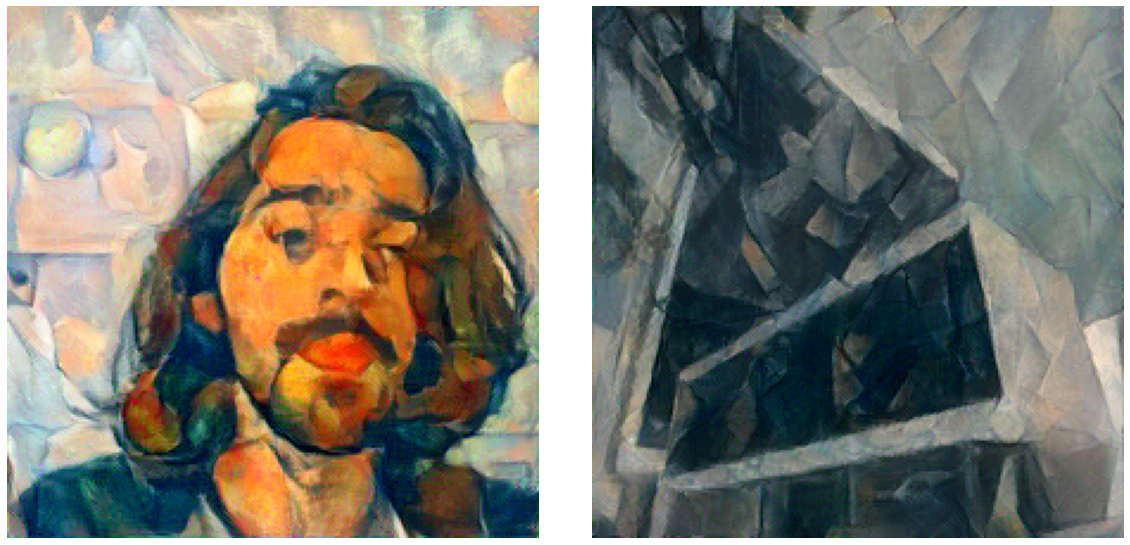

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(12)
for i, im in enumerate(images_style):
    img_to_plot = im.cpu().detach().permute(1, 2, 0).data.clamp_(0, 1).numpy()
    ax[i].imshow(img_to_plot)
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()